# Part 3.2.3
## Notes
- number of inputs is constant at 2+1
- number of outputs is constant at 1
- beta = 1 
- been run 3 times for 2, 3 and 4 hidden nodes respectively

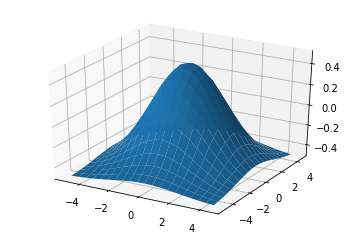

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.reshape(np.arange(-5, 5, 0.5, dtype=float), (-1,1))
y = np.reshape(np.arange(-5, 5, 0.5, dtype=float), (-1,1))
z = []

z = np.exp(-x*x*0.1) * np.exp(-y*y*0.1).T - 0.5

x2 = x[:,0::2]
y2 = y[:,0::2]
z2 = z[:,0::2]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(x,y,z)
# # ax.scatter(x,y,z)
# plt.show()

# setup targes and inputs. Each input col has r[0] = x, r[1] = y
# these corres. to targets 
targets = np.reshape(z, (1,len(x)**2))
[xx, yy] = np.meshgrid(x,y)
patterns = np.append( np.reshape(xx, (1,len(x)**2)), np.reshape(yy, (1,len(x)**2)), axis=0 ) 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,z)
# ax.scatter(x,y,z)
plt.show()

In [45]:
class MLP:
    num_input = 2 + 1
    num_output = 1
    beta = 3

    def __init__(self, inputs, targets, num_hid_nodes, epochs, learning_rate, hid_weight_inits, out_weight_inits):
        # input data
            # includes bias, 3 by many matrix
        self.inputs_with_bias = self.setup_input_data(inputs)
        self.training_input = self.inputs_with_bias[:,0::2].T
        self.testing_input = self.inputs_with_bias[:,1::4].T
        self.validation_input = self.inputs_with_bias[:,3::4].T

        # output data
        self.training_targets = np.reshape(targets[:,0::2], (-1,1))
        self.testing_targets = np.reshape(targets[:,1::4], (-1,1))
        self.validation_targets = np.reshape(targets[:,3::4], (-1,1))

        # percepron(s) parameters
        self.num_hid_nodes = num_hid_nodes  
        self.epochs = epochs
        self.learning_rate = learning_rate

        # training parameters
        self.hidden_weights = np.ones((self.num_input, num_hid_nodes))*hid_weight_inits
        self.output_weights = np.ones((self.num_hid_nodes+1, 1))*out_weight_inits

    def setup_input_data(self, inputs):
        inputs_with_bias = np.ones((np.shape(inputs)[0]+1,np.shape(inputs)[1]))*-1
        inputs_with_bias[:-1,:] = inputs
        return inputs_with_bias

    def fwd_pass(self, input_data):
        # activations from node1 in column 1,node2 in column 2... 
        hidden_layer_output = np.dot(input_data, self.hidden_weights)
        # columns = error per node
        self.activations = 1/(1+np.exp(-self.beta*hidden_layer_output))

        # include bias output node
        self.activations_with_bias = self.setup_input_data(self.activations.T)
        self.activations_with_bias = self.activations_with_bias.T
        # output of MLP in vector 
        output_layer_output = np.dot(self.activations_with_bias, self.output_weights)
        # self.output = 1/(1+np.exp(-self.beta*output_layer_output))    
        self.output = output_layer_output    
    
    def bck_pass(self,target_data):
        # output error
        self.output_error = (self.output - target_data)*self.output*(1-self.output)
        # self.output_error = 0.5*((self.output - target_data)**2)
        # hidden layer error
        # loop through each error term
        """Old stuff"""        
        self.hidden_layer_error = np.zeros((len(self.output_error),self.num_hid_nodes))
        for i in range(0, len(self.output_error)):
            # error vector for w_hidden_1, w_hidden_2, .... w_hidden_bias
            error = np.reshape(self.activations[i]*(1-self.activations[i]), (-1,1)) * (self.output_weights[0:num_hid_nodes]*self.output_error[i])
            error = np.reshape(error, (1,-1))
            # error for weight 1 in column 1, weight 2 in column 2 ... bias in last column
            self.hidden_layer_error[i] = error

    def average_errors(self, inputs):
        self.avg_output_error = sum(self.output_error)/np.shape(self.output_error)[0]
        self.avg_hidden_error = np.reshape(np.sum(self.hidden_layer_error, 0)/np.shape(self.hidden_layer_error)[0], (-1, 1))
        self.avg_activations = np.reshape(np.sum(self.activations_with_bias, 0)/np.shape(self.activations_with_bias)[0], (-1, 1))
        self.avg_input_data = np.reshape(np.sum(inputs, 0)/np.shape(inputs)[0], (-1, 1))
    
    def update_weights(self):
        # self.output_weights -= self.learning_rate*self.avg_output_error*self.avg_activations
        for i in range(0, len(self.training_input)):
            self.output_weights -= np.reshape( ((self.learning_rate*self.output_error[i]*self.activations_with_bias[i])/ len(self.training_input)), (-1,1))
            # 3 rows by NumOfNodes cols
            # does not include bias error
            self.hidden_weights -= ((self.learning_rate * np.reshape(self.hidden_layer_error[i][0:self.num_hid_nodes], (-1,1)) * np.reshape(self.training_input[i], (1,-1)))/len(self.training_input)).T
        # self.hidden_weights -= self.avg_input_data*(np.reshape(self.learning_rate*self.avg_hidden_error[0:self.num_hid_nodes], (1,-1)))

    def training(self):
        for e in range(0, epochs):
            self.fwd_pass(self.training_input)
            self.bck_pass(self.training_targets)
            self.average_errors(self.training_input)
            self.update_weights()
            print("Epoch: ", e, " has output error ", self.avg_output_error)
            if e == (epochs-1):
                # print(self.output_error)
                z = np.reshape(self.output, (-1,1))
                x = np.reshape(self.training_input[:,0], (-1,1))
                y = np.reshape(self.training_input[:,1], (-1,1))

                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                # ax.plot_surface(x,y,z)
                ax.scatter(x,y,z)
                plt.title('Acquired')
                plt.show()
            # print(self.output_weights)
                
    def testing(self, inputs):
        self.fwd_pass(inputs)
        return self.output
    
    def test_nn(self):
        z = np.reshape(self.testing(self.testing_input), (-1,1))

        # self.z = np.reshape(self.testing_targets[:,0], (-1,1))
        x = np.reshape(self.testing_input[:,0], (-1,1))
        y = np.reshape(self.testing_input[:,1], (-1,1))

        # self.training_error = self.testing_targets - z  
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        # ax.plot_surface(x,y,z)
        ax.scatter(x,y,z)
        plt.title('Acquired')
        plt.show()
        
        z = np.reshape(self.testing_targets[:,0], (-1,1))  
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        # ax.plot_surface(x,y,z)
        ax.scatter(x,y,z)
        plt.title('Required')
        plt.show()

Epoch:  0  has output error  [0.07693356]
Epoch:  1  has output error  [0.0738515]
Epoch:  2  has output error  [0.07102853]
Epoch:  3  has output error  [0.06843854]
Epoch:  4  has output error  [0.06605876]
Epoch:  5  has output error  [0.06386923]
Epoch:  6  has output error  [0.06185244]
Epoch:  7  has output error  [0.05999295]
Epoch:  8  has output error  [0.0582771]
Epoch:  9  has output error  [0.05669281]
Epoch:  10  has output error  [0.05522932]
Epoch:  11  has output error  [0.05387706]
Epoch:  12  has output error  [0.0526275]
Epoch:  13  has output error  [0.05147299]
Epoch:  14  has output error  [0.0504067]
Epoch:  15  has output error  [0.04942249]
Epoch:  16  has output error  [0.04851486]
Epoch:  17  has output error  [0.04767883]
Epoch:  18  has output error  [0.04690996]
Epoch:  19  has output error  [0.04620422]
Epoch:  20  has output error  [0.045558]
Epoch:  21  has output error  [0.04496803]
Epoch:  22  has output error  [0.04443138]
Epoch:  23  has output erro

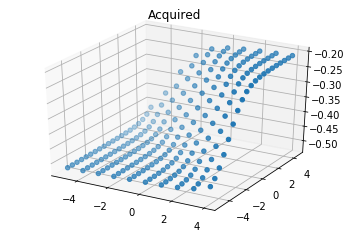

In [46]:
import random
#Generate 5 random numbers between 10 and 30
def randoms(num):
    lst = []
    for i in range (0, num):
        n = random.randint(-70,70)
        n = n/100
        lst.append(n)
    return lst

num_hid_nodes = 2
epochs = 66
learning_rate = 0.1
# must have 1 row and num_hid_nodes columns
hid_weight_inits = randoms(num_hid_nodes)
# must have 1 col and num_hid_nodes+1 rows
out_weight_inits = np.reshape(randoms(num_hid_nodes+1), (-1,1))

mlp_4_hidden_nodes = MLP(patterns, targets, num_hid_nodes, epochs, learning_rate, hid_weight_inits, out_weight_inits)


mlp_4_hidden_nodes.training()


In [47]:
mlp_4_hidden_nodes.hidden_weights
# mlp_4_hidden_nodes.output_weights
# mlp_4_hidden_nodes.hidden_layer_error[1][0:4]
# mlp_4_hidden_nodes.avg_output_error
# mlp_4_hidden_nodes.avg_hidden_error
# mlp_4_hidden_nodes.activations_with_bias
# mlp_4_hidden_nodes.output_weights[0:4]
mlp_4_hidden_nodes.hidden_layer_error[0]

array([2.50759635e-10, 4.95507651e-06])

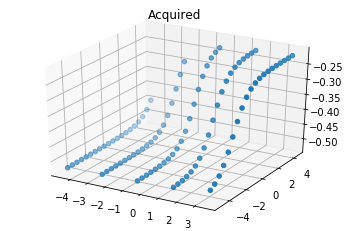

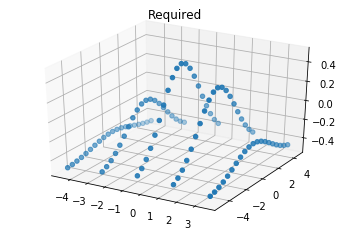

In [48]:
mlp_4_hidden_nodes.test_nn()

In [49]:
mlp_4_hidden_nodes.training_error

AttributeError: 'MLP' object has no attribute 'training_error'